# Simulating with the compensation patch-clamp model

In the [last notebook](./artefacts-2-compensation.ipynb), 

We

In [2]:
import myokit
import numpy as np
import matplotlib.pyplot as plt

In [3]:
m = myokit.parse_model('''
[[model]]
desc: Compensated model
amp.Vm = -80
amp.Vp = -80
amp.Vo = -80
amp.Ve = -80
amp.Vr = -80

[amp]
alpha = 0.6
beta = 0.6
time = 0 [ms] in [ms] bind time
I = 50 [pA] in [pA]
E = 1 [mV] in [mV]
Vc = -20 [mV] in [mV]
Cm = 40 [pF] in [pF]
Cm_est = 40 [pF] in [pF]
Cp = 4.5 [pF] in [pF]
Cp_est = 4.5 [pF] in [pF]
Cf = 0.3 [pF] in [pF]
Rs = 0.01 [GOhm] in [GOhm]
Rs_est = 0.01 [GOhm] in [GOhm]
Rf = 0.025 [GOhm] in [GOhm]
tau_amp = 50e-6 [ms] in [ms]
tau_sum = 40e-3 [ms] in [ms]
dot(Vm) = (Vp + E - Vm) / (Rs * Cm) - I / Cm
    in [mV]
dot(Vp) = ((Vo - Vp) / Rf - (Vp + E - Vm) / Rs +
            Cf * dot(Vo) + Cm * dot(Ve) + Cp * dot(Vr)
          ) / (Cp + Cf) : Eq 2a
    in [mV]
dot(Vo) = (Vr - Vp) / tau_amp
    in [mV]
dot(Ve) = (Vc - Ve) / if(tau < 1e-12 [ms], 1e-12 [ms], tau)
    in [mV]
    tau = (1 - beta) * Rs_est * Cm_est
        in [ms]
dot(Vr) = (Vc + alpha * Rs_est * I_obs + beta * Rs_est * Cm_est * dot(Ve) - Vr) / tau_sum
    in [mV]
I_obs = (Vo - Vr) / Rf
    in [pA]
''')
m.check_units(myokit.UNIT_STRICT)

In [4]:
t1 = 3
t2 = 0.6

def plot(m, d, axes=None, label=None, ls=None, altins=False, t_zoom=t2):
    if axes is None:
        fig = plt.figure(figsize=(15, 12))
        
        # Top left: Vm
        ax1 = fig.add_subplot(3, 2, 1)
        ax1.set_ylabel('Vm (mV)')
        
        # Top right: Vo
        ax2 = fig.add_subplot(3, 2, 2)
        ax2.set_ylabel('Vo (mV)')
        ax2.set_xlabel('Time (ms)')
        ins2 = ax2.inset_axes((0.3, 0.35 if altins else 0.10, 0.65, 0.50))
        ins2.set_xlim(-0.005, t_zoom)
        ins2.patch.set_alpha(0.5)

        # Middle left: Vp
        ax3 = fig.add_subplot(3, 2, 3)
        ax3.set_xlabel('Time (ms)')
        ax3.set_ylabel('Vp (mV)')
        ins3 = ax3.inset_axes((0.3, 0.10, 0.65, 0.50))
        ins3.set_xlim(-0.005, t_zoom)
        ins3.patch.set_alpha(0.5)

        # Middle right: V_ref
        ax4 = fig.add_subplot(3, 2, 4)
        ax4.set_xlabel('Time (ms)')
        ax4.set_ylabel('Vref (mV)')
        ins4 = ax4.inset_axes((0.3, 0.10, 0.65, 0.50))
        ins4.set_xlim(-0.005, t_zoom)
        ins4.patch.set_alpha(0.5)
        
        # Lower: I_obs
        ax5 = fig.add_subplot(3, 1, 3)
        ax5.set_xlabel('Time (ms)')
        ax5.set_ylabel('Recorded I (pA)')
        ins5 = ax5.inset_axes((0.3, 0.35 if altins else 0.10, 0.65, 0.50))
        ins5.set_xlim(-0.001, t_zoom)
        ins5.patch.set_alpha(0.5)

        kw = dict(color='#aaa', ls='--')
        ax1.axhline(m.get('amp.Vm').initial_value().eval(), label='Vm(t=0)', **kw)
        ax1.axhline(m.get('amp.Vc').eval(), label='Vc', **kw)
        ax2.axhline(m.get('amp.Vc').eval(), label='Vc', **kw)
        ax3.axhline(m.get('amp.Vc').eval(), label='Vc', **kw)
        ax4.axhline(m.get('amp.Vc').eval(), label='Vc', **kw)
    else:
        [ax1, ax2, ax3, ax4, ax5, ins2, ins3, ins4, ins5] = axes
        
    ax1.plot(d.time(), d['amp.Vm'], label=label, ls=ls)
    if 'amp.Vo' in d:
        ax2.plot(d.time(), d['amp.Vo'], ls=ls)
        ins2.plot(d.time(), d['amp.Vo'], ls=ls)
    ax3.plot(d.time(), d['amp.Vp'], ls=ls)
    ins3.plot(d.time(), d['amp.Vp'], ls=ls)
    ax4.plot(d.time(), d['amp.Vr'], ls=ls)
    ins4.plot(d.time(), d['amp.Vr'], ls=ls)
    ax5.plot(d.time(), d['amp.I_obs'], ls=ls)
    ins5.plot(d.time(), d['amp.I_obs'], ls=ls)
    
    return [ax1, ax2, ax3, ax4, ax5, ins2, ins3, ins4, ins5]


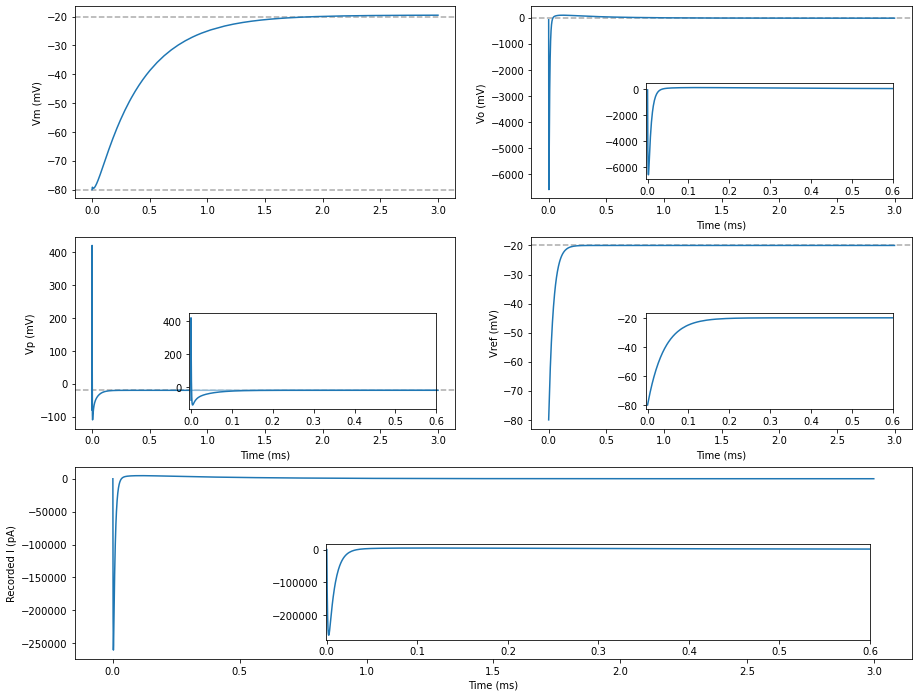

In [6]:
s = myokit.Simulation(m)
s.set_constant('amp.alpha', 0)
s.set_constant('amp.beta', 0)
s.set_constant('amp.Cm_est', 0)
s.set_constant('amp.Cp_est', 0)
dA = s.run(3)

plot(m, dA)
plt.show()

## Conclusion